In [1]:
import numpy as np
from mpl_toolkits import mplot3d
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl
from numpy import arange,array,ones,linalg
from scipy.optimize import minimize
from scipy import stats

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
import math

from scipy.ndimage import gaussian_filter1d

In [2]:
SGA_color_params = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')
SGA_color_params

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

## Masking -1.0 and outlier values, calculating r50 in R band for color gradient calculation

In [188]:
# Masking out -1.0 unmeasured values
boolean = SGA_color_params['G_MAG_SB26'] < 0
SGA_color_params['G_MAG_SB26'][boolean] = np.nan
boolean = SGA_color_params['R_MAG_SB26'] < 0
SGA_color_params['R_MAG_SB26'][boolean] = np.nan
boolean = SGA_color_params['Z_MAG_SB26'] < 0
SGA_color_params['Z_MAG_SB26'][boolean] = np.nan

# Masking out outlier values on (R,G,Z)_MAG_SB26
boolean2 = SGA_color_params['G_MAG_SB26'] > 47.0
SGA_color_params['G_MAG_SB26'][boolean2] = np.nan

g_mag_sb26 = SGA_color_params['G_MAG_SB26']
r_mag_sb26 = SGA_color_params['R_MAG_SB26']
z_mag_sb26 = SGA_color_params['Z_MAG_SB26']

In [189]:
color_index_g_z = g_mag_sb26 - z_mag_sb26
color_index_g_r = g_mag_sb26 - r_mag_sb26
color_index_r_z = r_mag_sb26 - z_mag_sb26
SGA_color_params.add_column(col=color_index_g_z, name ="COLOR G-Z")
SGA_color_params.add_column(col=color_index_g_r, name ="COLOR G-R")
SGA_color_params.add_column(col=color_index_r_z, name ="COLOR R-Z")

In [190]:
# Masking -1.0 unmeasured values from a1, a2, and m0 in R band
SGA_color_params['R_COG_PARAMS_ALPHA1'][SGA_color_params['R_COG_PARAMS_ALPHA1'] < 0] = np.NaN
SGA_color_params['R_COG_PARAMS_ALPHA2'][SGA_color_params['R_COG_PARAMS_ALPHA2'] < 0] = np.NaN
SGA_color_params['R_COG_PARAMS_M0'][SGA_color_params['R_COG_PARAMS_M0'] < 0] = np.NaN
SGA_color_params['R_COG_PARAMS_MTOT'][SGA_color_params['R_COG_PARAMS_MTOT'] < 0] = np.NaN
# Mask outliers in m0 for R band (masks 3 values)
SGA_color_params['R_COG_PARAMS_M0'][SGA_color_params['R_COG_PARAMS_M0'] == 20859238000000.0] = np.NaN
SGA_color_params['R_COG_PARAMS_M0'][SGA_color_params['R_COG_PARAMS_M0'] == 244922530000.0] = np.NaN
SGA_color_params['R_COG_PARAMS_M0'][SGA_color_params['R_COG_PARAMS_M0'] == 3147101600000.0] = np.NaN

alpha_1_r = SGA_color_params['R_COG_PARAMS_ALPHA1']
alpha_2_r = SGA_color_params['R_COG_PARAMS_ALPHA2']
m0_r = SGA_color_params['R_COG_PARAMS_M0']
m_tot_r = SGA_color_params['R_COG_PARAMS_MTOT']
r0 = 10.0

np.unique(alpha_2_r)

5.9370144e-19
4.1368956e-13
1.9048563e-11
6.204767e-07
5.9147173e-06
0.00016351572
0.021419624
0.06790527
0.15136126
0.17543407
0.17648286


In [191]:
# Calculation of r50_R
exp_factor50_r = (-1.0 * np.log10(0.5)) / (0.4 * m0_r)
inside_bracket50_r = (((np.exp(exp_factor50_r)) - 1.0) / alpha_1_r) ** (-1.0 / alpha_2_r)
r50_r = r0 * inside_bracket50_r

#This masks 2 values
r50_r[r50_r > 30000.0] = np.NaN
# This masks 39 values
r50_r[r50_r == 0.0] = np.NaN
np.unique(r50_r)

/tmp/ipykernel_1916085/2446688229.py:3: RuntimeWarning: overflow encountered in exp
  inside_bracket50_r = (((np.exp(exp_factor50_r)) - 1.0) / alpha_1_r) ** (-1.0 / alpha_2_r)
/tmp/ipykernel_1916085/2446688229.py:3: RuntimeWarning: overflow encountered in true_divide
  inside_bracket50_r = (((np.exp(exp_factor50_r)) - 1.0) / alpha_1_r) ** (-1.0 / alpha_2_r)


0.006731024
0.0093828365
0.028468091
0.03246683
0.033355847
0.03661721
0.03683027
0.044697095
0.05215239
0.084255785
0.08526218


In [192]:
SGA_color_params.add_column(col=r50_r, name = "R50_R")

In [193]:
# Masking -1.0 unmeasured values from a1, a2, and m0 in Z band 
SGA_color_params['Z_COG_PARAMS_ALPHA1'][SGA_color_params['Z_COG_PARAMS_ALPHA1'] < 0] = np.NaN
SGA_color_params['Z_COG_PARAMS_ALPHA2'][SGA_color_params['Z_COG_PARAMS_ALPHA2'] < 0] = np.NaN
SGA_color_params['Z_COG_PARAMS_M0'][SGA_color_params['Z_COG_PARAMS_M0'] < 0] = np.NaN
SGA_color_params['Z_COG_PARAMS_MTOT'][SGA_color_params['Z_COG_PARAMS_MTOT'] < 0] = np.NaN

# Masking outlier in M0
SGA_color_params['Z_COG_PARAMS_M0'][SGA_color_params['Z_COG_PARAMS_M0'] == 3816406600000.0] = np.NaN

alpha_1_z = SGA_color_params['Z_COG_PARAMS_ALPHA1']
alpha_2_z = SGA_color_params['Z_COG_PARAMS_ALPHA2']
m0_z = SGA_color_params['Z_COG_PARAMS_M0']
m_tot_z = SGA_color_params['Z_COG_PARAMS_MTOT']

In [194]:
# Masking -1.0 unmeasured values from a1, a2, and m0 in G band 
SGA_color_params['G_COG_PARAMS_ALPHA1'][SGA_color_params['G_COG_PARAMS_ALPHA1'] < 0] = np.NaN
SGA_color_params['G_COG_PARAMS_ALPHA2'][SGA_color_params['G_COG_PARAMS_ALPHA2'] < 0] = np.NaN
SGA_color_params['G_COG_PARAMS_M0'][SGA_color_params['G_COG_PARAMS_M0'] < 0] = np.NaN
SGA_color_params['G_COG_PARAMS_MTOT'][SGA_color_params['G_COG_PARAMS_MTOT'] < 0] = np.NaN
# Mask oulier in M0 (2 values)
SGA_color_params['G_COG_PARAMS_M0'][SGA_color_params['G_COG_PARAMS_M0'] > 600000000.0] = np.NaN

r0 = 10.0
alpha_1_g = SGA_color_params['G_COG_PARAMS_ALPHA1']
alpha_2_g = SGA_color_params['G_COG_PARAMS_ALPHA2']
m0_g = SGA_color_params['G_COG_PARAMS_M0']
m_tot_g = SGA_color_params['G_COG_PARAMS_MTOT']

# Color Gradient

### Using expression for $m(r)$ given in ellipse-fitting model from SGA, where:
###  $m(r_{50}) = m_{tot} + m_0\log_{e}[1 + \alpha_{1}(\frac{r_{50}}{r_0})^{-\alpha_{2}}]$ 
### Calculate $\Delta$(g-i) = $(g-i)(r_{50} < {R26})$ - $(g-i)(r < r_{50})$
### In terms of $m({R26})$ and $m(r_{50})$, expression follows: 
### $(i)(r_{50} < r_{90}) = -2.5\log_{10}(\frac{10^\frac{-m(r_{R26})}{2.5} -  10^\frac{-m(r_{50})}{2.5}}{10^\frac{-m(r_{50})}{2.5}}))$

In [195]:
# Do calculation for R band m(r50)
r0 = 10.0
power_50 = np.power((r50_r / r0), (-1.0 * alpha_2_r))
inside_log_term50_r = (1.0 + (alpha_1_r * power_50))
m_r50_R = m_tot_r + (m0_r * (np.log(inside_log_term50_r)))
np.unique(m_r50_R)

8.33055
8.575362
8.789363
8.800539
8.978004
9.029493
9.039214
9.081268
9.084181
9.099924
9.130221


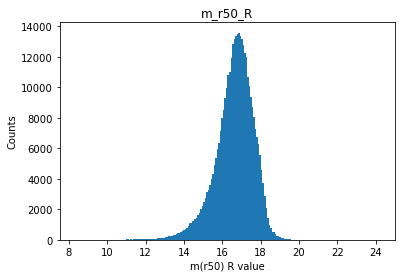

In [196]:
plt.hist(m_r50_R, bins=200)
plt.title('m_r50_R')
plt.ylabel('Counts')
plt.xlabel('m(r50) R value')
plt.show()

In [197]:
# Do calculation for delta R between R26(max r) and r(50)
first_term = 10**(-r_mag_sb26 / 2.5)
second_term = 10**(-m_r50_R / 2.5)
delta_r26_50 = (-2.5) * np.log10((first_term - second_term) / second_term)
np.unique(delta_r26_50)

/tmp/ipykernel_1916085/3314189958.py:4: RuntimeWarning: invalid value encountered in log10
  delta_r26_50 = (-2.5) * np.log10((first_term - second_term) / second_term)


-3.511485
-3.358438
-2.5312529
-2.399689
-2.2971582
-2.1000547
-2.0733883
-2.0224833
-1.9819088
-1.9157479
-1.6530912


In [198]:
# Do calculation for Z band m(r50)
power_50_z = np.power((r50_r / r0), (-1.0 * alpha_2_z))
inside_log_term50_z = (1.0 + (alpha_1_z * power_50_z))
m_r50_Z = m_tot_z + (m0_z * (np.log(inside_log_term50_z)))

# Masks 13 values
m_r50_Z[m_r50_Z == np.inf] = np.NaN

# Masks 20 values 
m_r50_Z[m_r50_Z > 26.0] = np.NaN

/tmp/ipykernel_1916085/4209043840.py:2: RuntimeWarning: overflow encountered in power
  power_50_z = np.power((r50_r / r0), (-1.0 * alpha_2_z))
/tmp/ipykernel_1916085/4209043840.py:3: RuntimeWarning: overflow encountered in multiply
  inside_log_term50_z = (1.0 + (alpha_1_z * power_50_z))


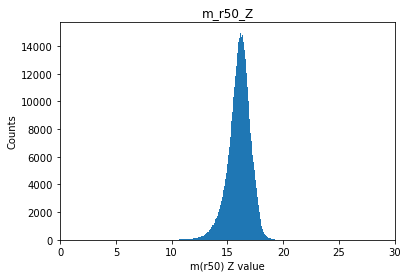

In [199]:
plt.hist(m_r50_Z, bins=200)
plt.xlim(0.0, 30.0)
plt.title('m_r50_Z')
plt.ylabel('Counts')
plt.xlabel('m(r50) Z value')
plt.show()

In [200]:
# Do calculation for delta Z between r(90) and r(50)
first_term = 10**(-z_mag_sb26 / 2.5)
second_term = 10**(-m_r50_Z / 2.5)
delta_z26_50 = (-2.5) * np.log10((first_term - second_term) / second_term)
np.unique(delta_z26_50)

/tmp/ipykernel_1916085/2882423274.py:4: RuntimeWarning: invalid value encountered in log10
  delta_z26_50 = (-2.5) * np.log10((first_term - second_term) / second_term)


-11.41686
-10.693402
-8.966645
-8.402737
-6.2741466
-5.743389
-5.5135794
-5.322316
-5.094113
-4.9544277
-4.915548


In [201]:
# Do calculation for G band m(r50)
power_50_g = (r50_r / r0) ** (-alpha_2_g)
inside_log_term50_g = (1.0 + (alpha_1_g * power_50_g))
m_r50_G = m_tot_g + (m0_g * (np.log(inside_log_term50_g)))
m_r50_G[m_r50_G == np.inf] = np.NaN

# Mask 25 values
m_r50_G[m_r50_G > 26.0] = np.NaN
np.unique(m_r50_G)

/tmp/ipykernel_1916085/1705012240.py:2: RuntimeWarning: overflow encountered in power
  power_50_g = (r50_r / r0) ** (-alpha_2_g)
/tmp/ipykernel_1916085/1705012240.py:3: RuntimeWarning: overflow encountered in multiply
  inside_log_term50_g = (1.0 + (alpha_1_g * power_50_g))


8.516469
9.129056
9.433303
9.475659
9.542304
9.724444
9.788385
9.807539
9.82247
9.894693
9.915831


In [202]:
SGA_color_params.add_column(col=m_r50_G, name = "m(r50)_G")
SGA_color_params.add_column(col=m_r50_Z, name = "m(r50)_Z")
SGA_color_params.add_column(col=m_r50_R, name = "m(r50)_R")

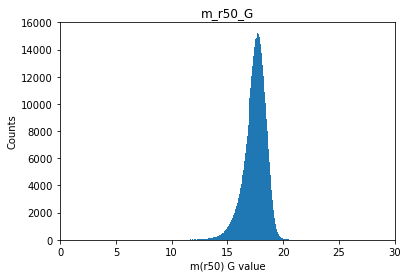

In [203]:
plt.hist(m_r50_G, bins=200)
plt.xlim(0.0, 30.0)
plt.title('m_r50_G')
plt.ylabel('Counts')
plt.xlabel('m(r50) G value')
plt.show()

In [204]:
# Do calculation for delta G between R26(max r) and r(50)
first_term = 10**((-0.4 * g_mag_sb26))
second_term = 10**((-0.4 * m_r50_G))
delta_g26_50 = (-2.5) * np.log10((first_term - second_term) / second_term)
np.unique(delta_g26_50)

/tmp/ipykernel_1916085/2621478421.py:4: RuntimeWarning: invalid value encountered in log10
  delta_g26_50 = (-2.5) * np.log10((first_term - second_term) / second_term)


-11.192072
-9.404933
-7.1901417
-7.090264
-5.914363
-5.6921005
-5.2108097
-5.192589
-5.1446877
-4.6987815
-4.654196


In [205]:
# Actual gradients between m(r90) and m(r50), these are the tiny values
Grad_gz_r26_50 = delta_g26_50 - delta_z26_50
Grad_gr_r26_50 = delta_g26_50 - delta_r26_50
Grad_rz_r26_50 = delta_r26_50 - delta_z26_50

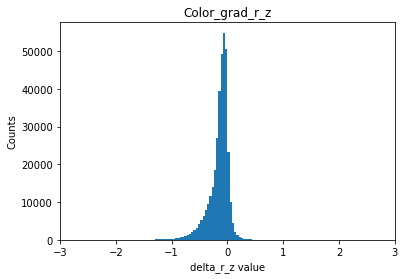

In [206]:
plt.hist(Grad_rz_r26_50, bins=500)
plt.xlim(-3.0, 3.0)
plt.title('Color_grad_r_z')
plt.ylabel('Counts')
plt.xlabel('delta_r_z value')
plt.show()

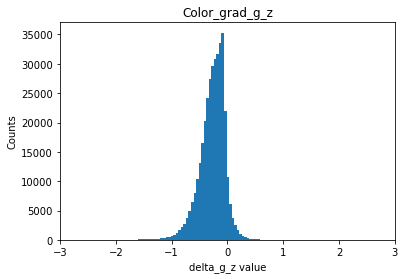

In [207]:
plt.hist(Grad_gz_r26_50, bins=500)
plt.xlim(-3.0, 3.0)
plt.title('Color_grad_g_z')
plt.ylabel('Counts')
plt.xlabel('delta_g_z value')
plt.show()

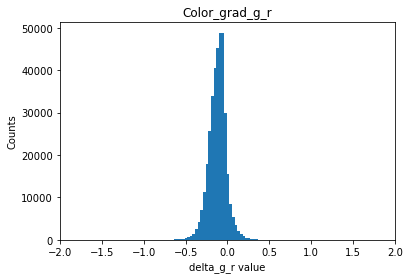

In [208]:
plt.hist(Grad_gr_r26_50, bins=500)
plt.xlim(-2.0, 2.0)
plt.title('Color_grad_g_r')
plt.ylabel('Counts')
plt.xlabel('delta_g_r value')
plt.show()

In [217]:
# Filter for main values only (see histograms for reference)

Grad_gr_r26_50[Grad_gr_r26_50 > 1.5] = np.NaN
Grad_gr_r26_50[Grad_gr_r26_50 < -1.5] = np.NaN
Grad_gz_r26_50[Grad_gz_r26_50 > 1.5] = np.NaN
Grad_gz_r26_50[Grad_gz_r26_50 < -2.5] = np.NaN
Grad_rz_r26_50[Grad_rz_r26_50 > 1.5] = np.NaN
Grad_rz_r26_50[Grad_rz_r26_50 < -2.5] = np.NaN

In [221]:
SGA_color_params.add_column(col=Grad_gz_r26_50, name = "GRADIENT_G-Z")
SGA_color_params.add_column(col=Grad_gr_r26_50, name = "GRADIENT_G-R")
SGA_color_params.add_column(col=Grad_rz_r26_50, name = "GRADIENT_R-Z")

In [222]:
SGA_color_params.write('SGA_Color_Grad.fits', overwrite = True)

In [224]:
Calculated_params = Table([SGA_color_params['MORPHTYPE'], SGA_color_params['GRADIENT_G-Z'], SGA_color_params['GRADIENT_G-R'], SGA_color_params['GRADIENT_R-Z']])
Calculated_params

MORPHTYPE,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z
bytes21,float32,float32,float32
S?,-0.051613025,-0.121877454,0.07026443
Sc,-0.28590974,-0.17437452,-0.11153522
S?,-0.14042757,-0.097195834,-0.04323174
Sbc,-0.3388191,-0.24295844,-0.09586063
E,-0.5760583,-0.13036215,-0.44569615
S?,-0.44075775,-0.10728051,-0.33347723
S?,nan,nan,nan
Sbc,-0.25257376,-0.1404431,-0.112130664
--,-0.5026129,-0.21152721,-0.2910857
